In [6]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import seaborn as sn
import datetime
import random
from datetime import date
from pprint import pprint
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import statistics 
from statistics import mode
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [7]:
def convert_strings_to_dates(dataframe, testset=False):
    frame = dataframe.copy()
    if testset:
        frame.dt = [date.fromisoformat(d) for d in frame.dt]
        frame.first_load_date = [date.fromisoformat(d) for d in frame.first_load_date]
        frame.ts_signup = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S+00:00') for d in frame.ts_signup]
        frame.ts_signup = [date(year=d.year, month=d.month, day=d.day) for d in frame.ts_signup]
    else:
        frame.dt = [date.fromisoformat(d) for d in frame.dt]
        frame.first_load_date = [date.fromisoformat(d) for d in frame.first_load_date]
        frame.most_recent_load_date = [date.fromisoformat(d) for d in frame.most_recent_load_date]
        frame.ts_signup = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S+00:00') for d in frame.ts_signup]
        frame.ts_signup = [date(year=d.year, month=d.month, day=d.day) for d in frame.ts_signup]
    return frame

In [8]:
def convert_date_to_int(dataframe, columns):
    frame = dataframe.copy()
    conversion = lambda dt_time: 10000*dt_time.year + 100*dt_time.month + dt_time.day
    
    for col in columns:
        frame[f'{col}'] = [conversion(d) for d in frame[f'{col}']]

    return frame

In [9]:
def aggregate_rows_by_driver_id(dataframe):
    '''
    Returns a new dataframe indexed by Driver ID using an optimal set of aggregations per column.
    This method will return a dataframe that only contains the columns listed below.
    Note: duplicate columns are inherently pruned (simply by not adding them below), so it is 
        safe to pass in the full dataframe and expect a pruned version in return. 
        Also note that the `id_driver` will now be the index of the dataframe and NOT its own column.
    '''
    minimum = 'min'
    maximum = 'max'
    median = 'median'
    random_mode = lambda x: random.choice(pd.Series.mode(x if isinstance(x, list) else list(x)))
    average = lambda x: pd.Series.mean(x)

    aggregation = {
        'dt': maximum,
        'weekday': random_mode,
        'dim_carrier_type': random_mode,
        'carrier_trucks': mode,
        'num_trucks': maximum,
        'interested_in_drayage': random_mode,
        'port_qualified': random_mode,
        'signup_source': random_mode,
        'ts_signup': maximum,
        'days_signup_to_approval': maximum,
        'driver_with_twic': mode,
        'dim_preferred_lanes': mode,
        'first_load_date': minimum,
        'loads': random_mode,
        'marketplace_loads_otr': maximum,
        'marketplace_loads_atlas': maximum,
        'marketplace_loads': maximum,
        'brokerage_loads_otr': maximum,
        'brokerage_loads_atlas': maximum,
        'brokerage_loads': maximum,
        'label': random_mode
    }

    return dataframe.groupby(['id_driver']).agg(aggregation)

In [10]:
def augment_boolean_columns(dataframe):
    frame = dataframe.copy()
    label_encoder = LabelEncoder()
    
    # Replacement (no new columns needed, just transform strings to 0 or 1)
    frame['interested_in_drayage'] = label_encoder.fit_transform(frame.interested_in_drayage)
    frame['port_qualified'] = label_encoder.fit_transform(frame.port_qualified)
    frame['driver_with_twic'] = label_encoder.fit_transform(frame.driver_with_twic)
    
    # Create new columns with more appropriate names, delete the old columns
    frame['self_owned'] = label_encoder.fit_transform(frame.dim_carrier_type)
    frame['mobile_signup'] = np.logical_xor(label_encoder.fit_transform(frame.signup_source), 1).astype(int)
    frame['has_route_preference'] = label_encoder.fit_transform(~frame.dim_preferred_lanes.isnull())
    frame.drop(columns=['dim_carrier_type', 'signup_source', 'dim_preferred_lanes'], inplace=True)
    
    return frame

In [11]:
def encode_categorical_columns(dataframe):
    frame = dataframe.copy()

    # Encode various truck types
    trucks = pd.get_dummies(frame.carrier_trucks)
    trucks.columns = ['truck-' + c.replace('[', '').replace(']', '').replace('"', '').replace(',', '').replace(' ', '-') for c in trucks.columns]
    
    # Encode the 7 different days of the week
    weekdays = pd.get_dummies(frame.weekday)
    weekdays.columns = [f'prefers-{x}'.lower() for x in weekdays.columns]
    
    # Drop the originals since they are no longer needed.
    frame.drop(columns=['carrier_trucks', 'weekday'], inplace=True)
    
    # Concatenate various new frames with the original and return
    result = pd.concat([frame, trucks, weekdays], axis=1)
    return result

In [12]:
def standardize_numericals(dataframe, columns=None):    
    scaler = StandardScaler()
    frame = None
    
    if columns:
        frame = dataframe[columns].copy()
    else:
        frame = dataframe.copy()
    
    x = scaler.fit_transform(frame)
    scaled_df = pd.DataFrame(x)
    scaled_df.columns = frame.columns

    
    if columns:
        frame = dataframe.copy()
        frame[columns] = scaled_df.values
    else:
        frame = scaled_df.copy()
    
    return frame

In [13]:
def impute_numericals(dataframe, columns, strategy='most_frequent', testset=False):
    frame = dataframe.copy()
    imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
    
    for col in columns:
        imp.fit(frame[f'{col}'].values.reshape(-1, 1))
        frame[f'{col}'] = imp.transform(frame[f'{col}'].values.reshape(-1, 1))
    
    return frame

In [14]:
def generate_labels(dataframe, loads_percentile, most_recent_percentile):
    label_encoder = LabelEncoder()
    frame = dataframe.copy()
    
    labels = (frame.total_loads > loads_percentile) & (frame.most_recent_load_date > most_recent_percentile)
    frame['label'] = label_encoder.fit_transform(labels)
    frame.drop(columns=['total_loads', 'most_recent_load_date'], inplace=True)
    
    return frame

In [15]:
def get_Xy(dataframe, aggregate=False, standardize=False, testdata=False):
    frame = dataframe.copy()
    scaler = StandardScaler()
    if not testdata:
        loads_75th_percentile = dataframe["total_loads"].quantile(0.75)
    most_recent_75th_percentile = date(year=2021, month=2, day=10)


    if testdata:
        frame = convert_strings_to_dates(frame, testset=True)
        frame = augment_boolean_columns(frame)
        frame = encode_categorical_columns(frame)
        frame = convert_date_to_int(frame, columns=['dt', 'ts_signup', 'first_load_date'])

        # The only columns not in the new frame should be booleans that are safely set to 0
        for col in dataframe.columns:
            if col not in frame.columns:
                frame[f'{col}'] = 0

        frame.drop(columns=['weekday'], inplace=True)
        frame = impute_numericals(frame, ['days_signup_to_approval'])

        if standardize:
            frame = standardize_numericals(frame)

        frame.sort_index(axis=1, inplace=True)
        return frame, None
    
    
    frame = convert_strings_to_dates(frame)
    
    if aggregate:
        frame = generate_labels(frame, loads_75th_percentile, most_recent_75th_percentile)
        frame = aggregate_rows_by_driver_id(frame)
        frame = augment_boolean_columns(frame)
        frame = encode_categorical_columns(frame)
        frame = convert_date_to_int(frame, columns=['dt', 'ts_signup', 'first_load_date'])

        labels = frame.label.copy()
        frame.drop(columns=['label'], inplace=True)
        
        if standardize:
            frame = standardize_numericals(frame)

        frame.sort_index(axis=1, inplace=True)
        
        return frame, labels
    else:
        frame = generate_labels(frame, loads_75th_percentile, most_recent_75th_percentile)
        frame = augment_boolean_columns(frame)
        frame = encode_categorical_columns(frame)
        frame = convert_date_to_int(frame, columns=['dt', 'ts_signup', 'first_load_date'])

        labels = frame.label.copy()
        frame.drop(columns=['label'], inplace=True)
        
        if standardize:
            frame = standardize_numericals(frame)

        frame.sort_index(axis=1, inplace=True)
        
        return frame, labels

## Load CSV to DataFrame

In [16]:
train_df = pd.read_csv('training_dataset_V3.csv')
test_df = pd.read_csv('score_V3.csv')

**Drops duplicates and unwanted columns**

In [17]:
train_Ids = train_df['Unnamed: 0']
train_df.drop(columns=['Unnamed: 0', 'load_day', 'ts_first_approved', 'dim_carrier_company_name', 'home_base_city', 'home_base_state', 'id_carrier_number', 'year'], inplace=True)
train_df.dropna(subset=['days_signup_to_approval', 'num_trucks'], inplace=True)

test_Ids = test_df['Unnamed: 0']
test_df.drop(columns=['Unnamed: 0', 'load_day', 'ts_first_approved', 'dim_carrier_company_name', 'home_base_city', 'home_base_state', 'id_carrier_number', 'year'], inplace=True)

---

# 1 - Generate Labels and 4 - Pipeline

In [18]:
# Use this when you want to generate output for Kaggle
X_train, y_train = get_Xy(train_df, standardize=True, aggregate=False, testdata=False)
X_test, _ = get_Xy(test_df, standardize=True, aggregate=False, testdata=True)

In [19]:
# testing the number of labels
np.sum(np.array(y_train)) / len(y_train)

0.1519867176947321

In [20]:
# Use this for training/testing your model
X, y = get_Xy(train_df, standardize=True, aggregate=False, testdata=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [21]:
X_train.shape, y_train.shape

((56857, 40), (56857,))

In [22]:
X_test.shape, y_test.shape

((14215, 40), (14215,))

# 3 - Statistical Analysis

In [23]:
X_train.describe()

,brokerage_loads,brokerage_loads_atlas,brokerage_loads_otr,days_signup_to_approval,driver_with_twic,dt,first_load_date,has_route_preference,id_driver,interested_in_drayage,...,truck-dryvan-poweronly,truck-dryvan-reefer,truck-flatbed,truck-poweronly,truck-poweronly-boxtruck,truck-poweronly-dryvan,truck-reefer,truck-reefer-dryvan,truck-reefer-poweronly,ts_signup
count,56857.000000,56857.000000,56857.000000,56857.000000,56857.000000,56857.000000,56857.000000,56857.000000,56857.000000,56857.000000,...,56857.000000,56857.000000,56857.000000,56857.000000,56857.000000,56857.000000,56857.000000,56857.000000,56857.000000,56857.000000
mean,0.001291,-0.001792,0.001516,-0.001651,-0.001632,0.001404,0.001034,0.002113,0.000904,0.000953,...,0.000987,0.001832,-0.002290,0.000620,-0.001824,0.001535,-0.003153,0.001876,0.000587,0.001339
std,1.005809,0.996811,1.005791,0.998182,0.999347,0.998114,0.997926,1.004517,0.998650,1.000009,...,1.001345,1.023511,0.963924,1.000139,0.986909,1.002302,0.965075,1.118042,1.016182,0.997848
min,-0.370722,-0.338059,-0.325523,-0.765626,-0.674178,-3.600150,-2.940555,-0.222133,-1.836534,-0.999100,...,-0.329038,-0.038465,-0.032284,-0.810912,-0.069740,-0.303405,-0.045835,-0.007502,-0.017992,-2.834942
25%,-0.359328,-0.338059,-0.325523,-0.765626,-0.674178,-0.253882,-0.509302,-0.222133,-0.733788,-0.999100,...,-0.329038,-0.038465,-0.032284,-0.810912,-0.069740,-0.303405,-0.045835,-0.007502,-0.017992,-0.282802
50%,-0.268171,-0.338059,-0.294331,-0.609370,-0.674178,-0.168575,0.282070,-0.222133,-0.064395,1.000901,...,-0.329038,-0.038465,-0.032284,-0.810912,-0.069740,-0.303405,-0.045835,-0.007502,-0.017992,-0.202457
75%,-0.006094,-0.271951,-0.030619,0.507476,1.483288,0.661694,1.074258,-0.222133,0.965675,1.000901,...,-0.329038,-0.038465,-0.032284,1.233179,-0.069740,-0.303405,-0.045835,-0.007502,-0.017992,0.624525
max,11.781670,7.837263,11.771224,3.468653,1.483288,1.454732,1.891341,4.501812,1.594182,1.000901,...,3.039161,25.997619,30.974706,1.233179,14.338921,3.295926,21.817270,133.292911,55.579555,2.322495


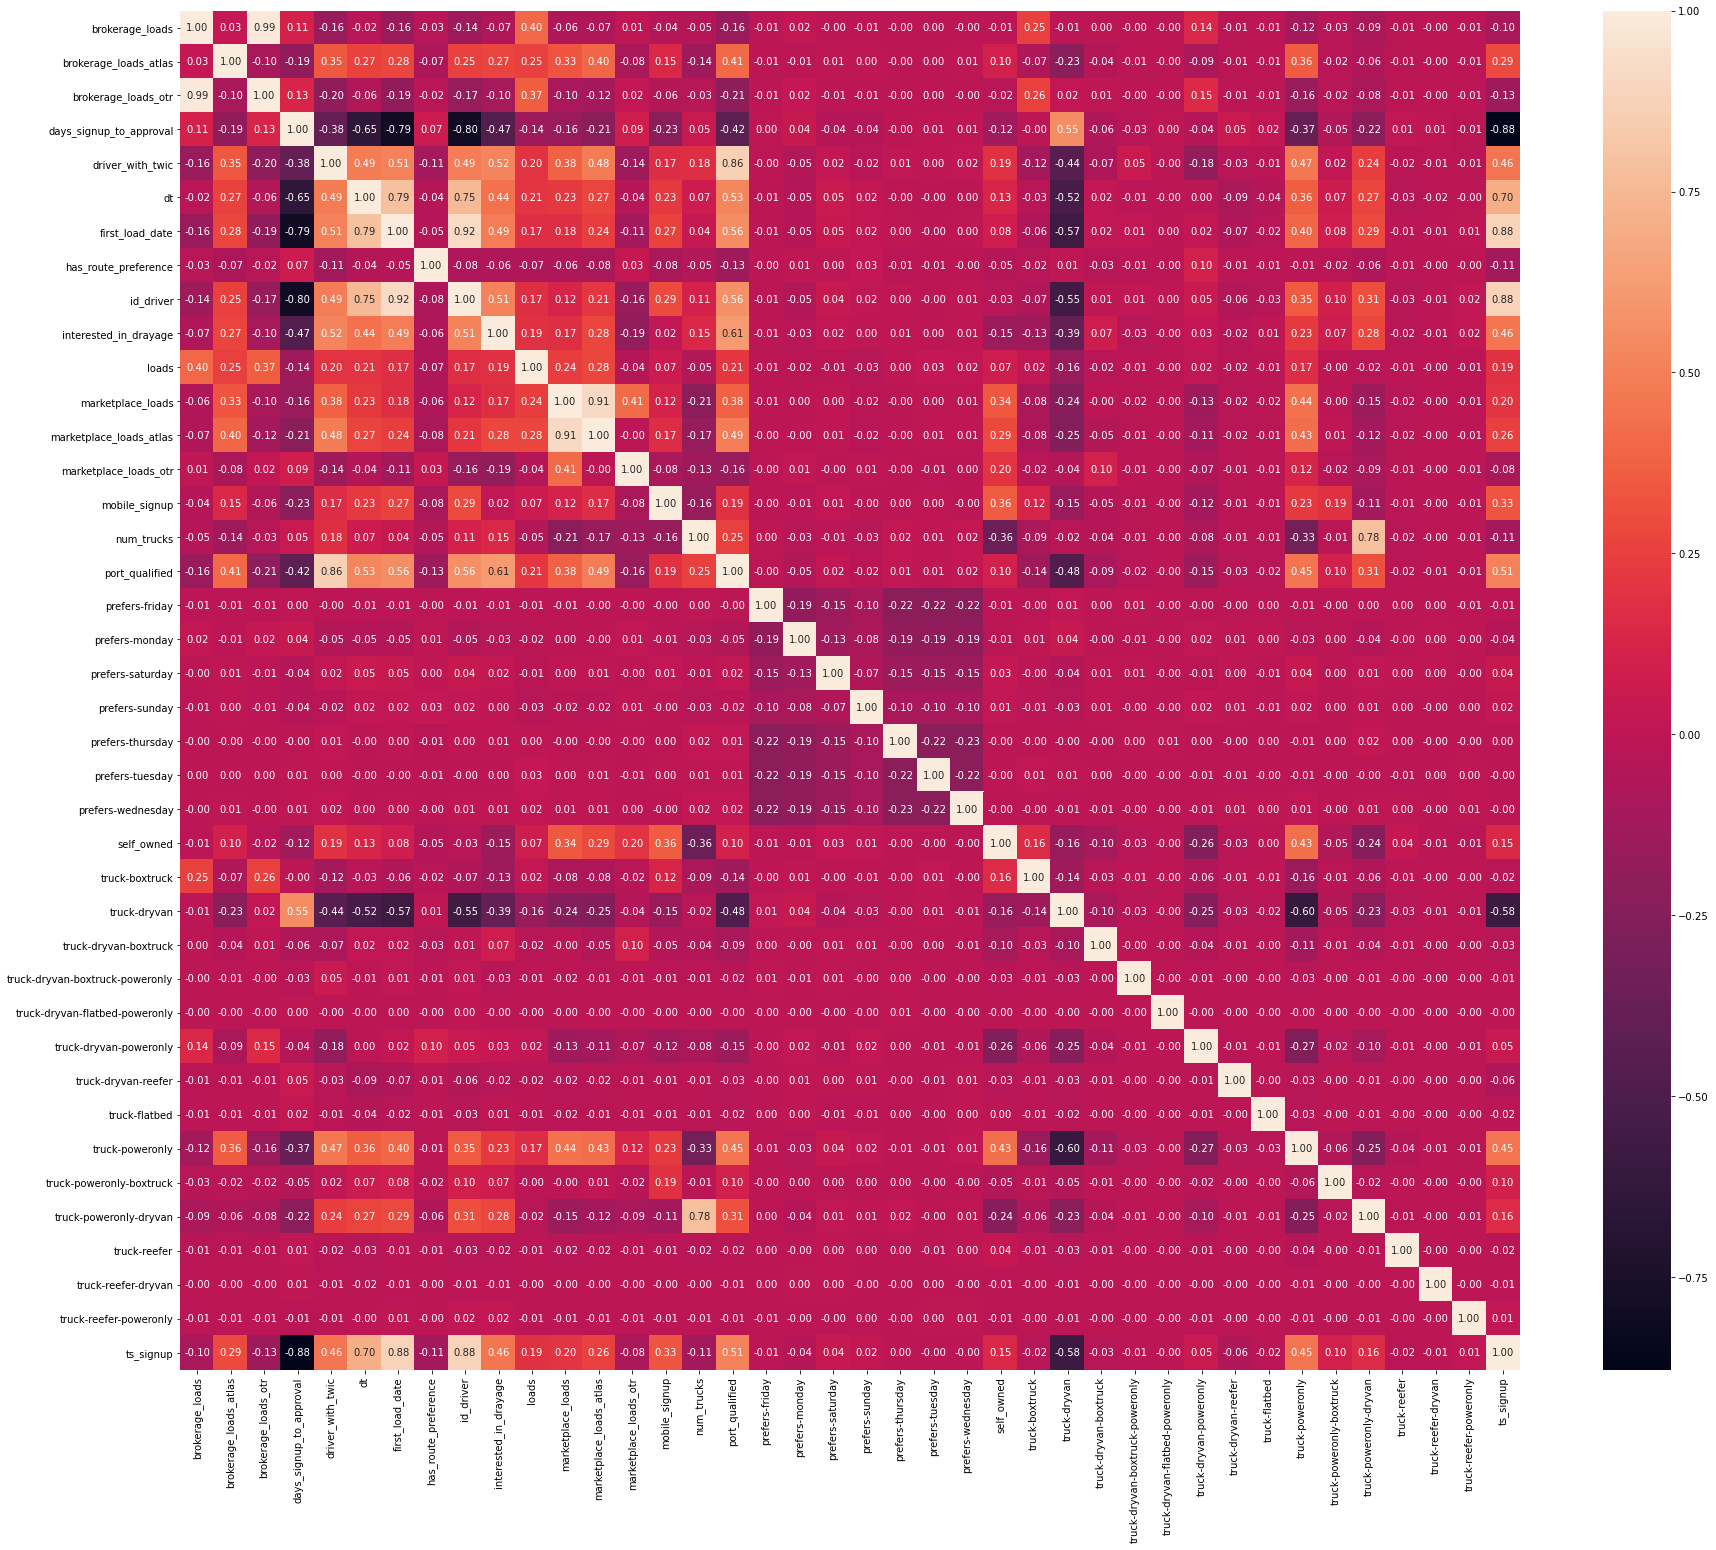

In [24]:
plt.figure(figsize=(30,25))
sn.heatmap(X_train.corr(), annot=True, fmt=".2f")
plt.show()

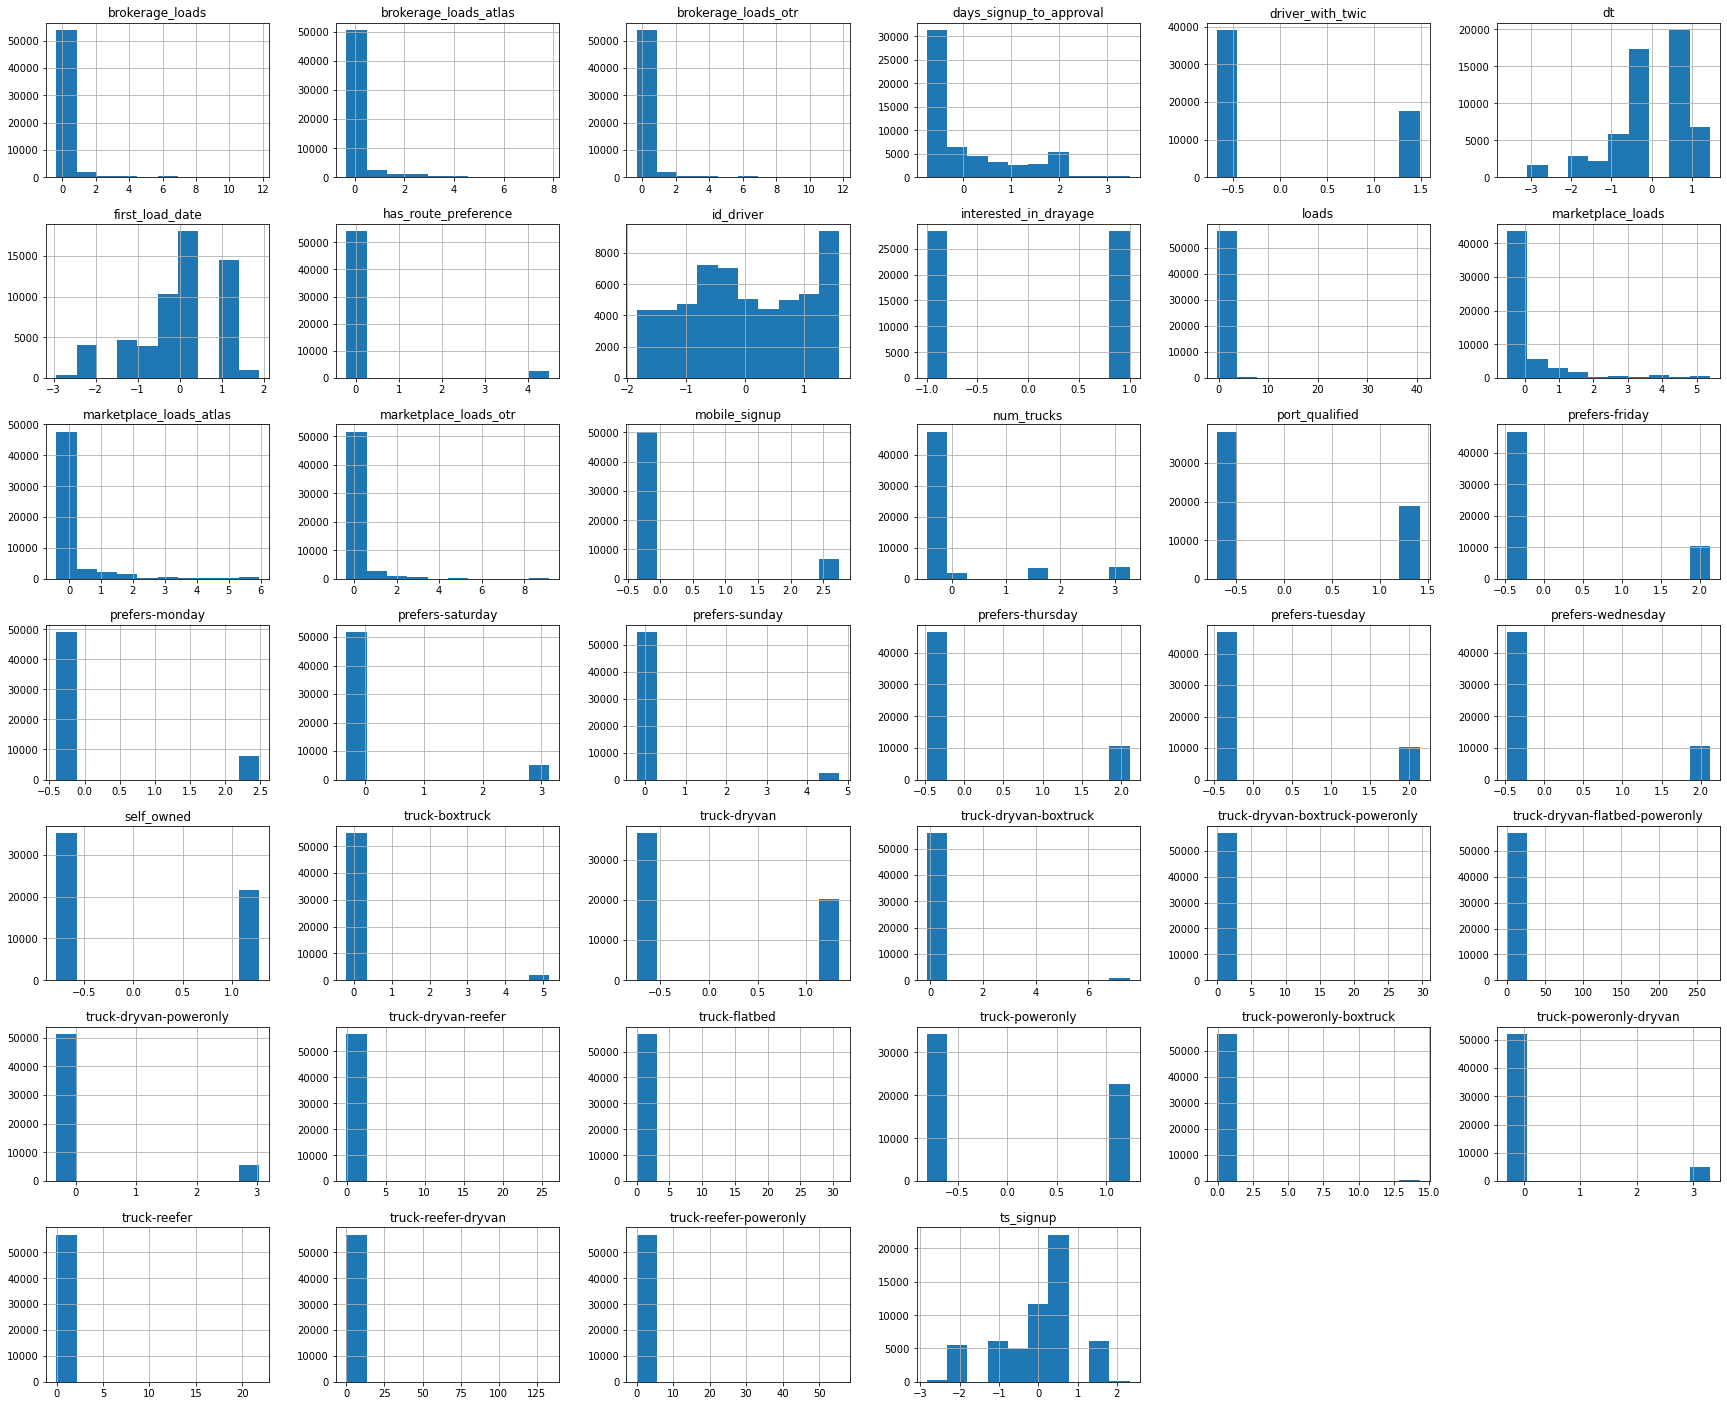

In [25]:
_ = X_train.hist(figsize=(30,25))

# 5 - Logistic Regression

In [117]:
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats as st
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingRegressor

MSE of test data = 0.078016
MSE of train data = 0.074608
R^2 of Test = 0.92198
R^2 of Train = 0.92539


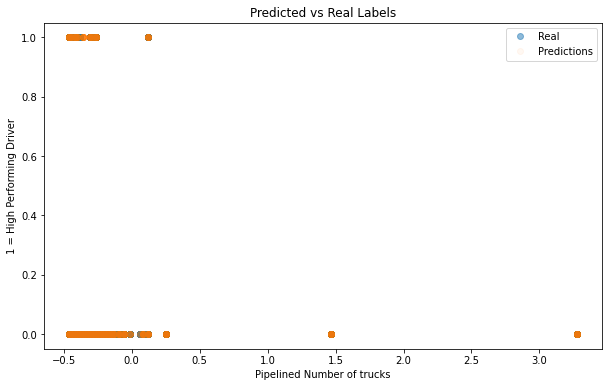

In [118]:
clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

# report scores 
r2_test = clf.score(X_test, y_test)
r2_train = clf.score(X_train, y_train)
mse_test = mean_squared_error(pred, y_test)
mse_train = mean_squared_error(y_train, clf.predict(X_train))

print(f'MSE of test data = {mse_test:.5}')
print(f'MSE of train data = {mse_train:.5}')
print(f'R^2 of Test = {r2_test:.5}')
print(f'R^2 of Train = {r2_train:.5}')

# plotting the y versus the predicted y
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(X_test.num_trucks, y_test, 'o', label="Real", alpha=0.5)
ax.plot(X_test.num_trucks, pred, 'o', label="Predictions", alpha=0.05)
ax.set_xlabel("Pipelined Number of trucks")
ax.set_ylabel("1 = High Performing Driver")
ax.set_title("Predicted vs Real Labels")
ax.legend()

In [119]:
n_estimators = 100
sample_size = 3148
model = BaggingRegressor(LogisticRegression(max_iter=200), 
                         n_estimators=n_estimators,
                         bootstrap=True, max_samples=sample_size)

model.fit(X_train, y_train)

BaggingRegressor(base_estimator=LogisticRegression(max_iter=200),
                 max_samples=3148, n_estimators=100)

In [120]:
tot_columns = len(X_train.columns)
intercept=[]
beta=[ [] for _ in range(tot_columns)]

for m in model.estimators_:
    intercept.append(m.intercept_)
    for i in range(tot_columns):
        beta[i].append(m.coef_[0][i])

coef_mean = []
coef_std = []

print(f'Intercept mean: {np.mean(intercept):<25.2f}std: {np.std(intercept):.2f}')
for i, b in enumerate(beta):
    print(f'Predictor {i} mean: {np.mean(beta[i]):<25.2f}std: {np.std(beta[i]):.2f}')
    coef_mean.append(np.mean(beta[i]))
    coef_std.append(np.std(beta[i]))

Intercept mean: -5.43                    std: 0.18
Predictor 0 mean: 1.65                     std: 0.12
Predictor 1 mean: 0.28                     std: 0.08
Predictor 2 mean: 1.61                     std: 0.12
Predictor 3 mean: -0.00                    std: 0.17
Predictor 4 mean: 0.15                     std: 0.13
Predictor 5 mean: 1.09                     std: 0.15
Predictor 6 mean: 0.31                     std: 0.17
Predictor 7 mean: -0.62                    std: 0.04
Predictor 8 mean: 0.22                     std: 0.21
Predictor 9 mean: -0.03                    std: 0.10
Predictor 10 mean: -0.27                    std: 0.11
Predictor 11 mean: 0.79                     std: 0.05
Predictor 12 mean: 0.83                     std: 0.07
Predictor 13 mean: 0.08                     std: 0.07
Predictor 14 mean: -0.15                    std: 0.06
Predictor 15 mean: -4.91                    std: 0.35
Predictor 16 mean: -0.36                    std: 0.18
Predictor 17 mean: -0.03                 

In [121]:
t_statistic = []
p_val = []
for i in range(tot_columns):
    stats = st.ttest_1samp(beta[i], 0)
    t_statistic.append(stats.statistic)
    p_val.append(stats.pvalue/2)

discard = {}
for i,p in enumerate(p_val):
    if p > 0.05:
        discard[i] = p
discard

{3: 0.46215966199665726,
 20: 0.10182715360571555,
 22: 0.3653358284595601,
 23: 0.13471635470677065,
 29: 0.3142431778550714,
 37: 0.1745016309555994}

In [122]:
X_sig_pred = X.copy()
X_sig_pred.drop(X_sig_pred.columns[list(discard.keys())],axis=1, inplace=True)
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X_sig_pred.columns 
vif_data["VIF"] = [variance_inflation_factor(X_sig_pred.values, i) for i in range(len(X_sig_pred.columns))]  
print('\n', vif_data, '\n')

vif_data.replace(np.inf, np.nan, inplace=True) 
vif_data.dropna(inplace=True) 
vif_data

keep_columns = list(vif_data.feature)
X_sig_pred = X_sig_pred[keep_columns]
X_sig_pred.info()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)



                             feature          VIF
0                   brokerage_loads          inf
1             brokerage_loads_atlas          inf
2               brokerage_loads_otr          inf
3                  driver_with_twic     4.351951
4                                dt     3.050479
5                   first_load_date     9.184147
6              has_route_preference     1.074755
7                         id_driver    10.166688
8             interested_in_drayage     2.014020
9                             loads     1.415092
10                marketplace_loads          inf
11          marketplace_loads_atlas          inf
12            marketplace_loads_otr          inf
13                    mobile_signup     1.460158
14                       num_trucks     3.864932
15                   port_qualified     6.103992
16                   prefers-friday     1.186917
17                   prefers-monday     1.164078
18                 prefers-saturday     1.119998
19                

In [123]:
X_train_sig, X_test_sig, y_train_sig, y_test_sig = train_test_split(X_sig_pred, y, test_size=0.20, random_state=42)

MSE of test data = 0.13746
MSE of train data = 0.13698
R^2 of Test = 0.86254
R^2 of Train = 0.86302

                            Feature  Coefficient
0                         Intercept    -4.257007
1                  driver_with_twic    -0.085869
2                                dt     0.974211
3                   first_load_date    -0.262728
4              has_route_preference    -1.371098
5                         id_driver    -0.681987
6             interested_in_drayage     0.059330
7                             loads     0.547641
8                     mobile_signup    -0.025734
9                        num_trucks    -3.141540
10                   port_qualified     0.307509
11                   prefers-friday    -0.019347
12                   prefers-monday     0.065985
13                 prefers-saturday     0.017275
14                 prefers-thursday     0.009441
15                       self_owned     0.184171
16                   truck-boxtruck     0.335473
17               

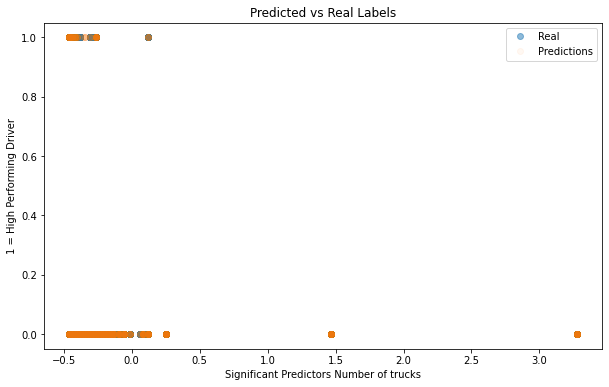

In [124]:
# train logistic model
clf = LogisticRegression(max_iter=200)
clf.fit(X_train_sig, y_train_sig)
pred = clf.predict(X_test_sig)

# report scores 
r2_test = clf.score(X_test_sig, y_test_sig)
r2_train = clf.score(X_train_sig, y_train_sig)
mse_test = mean_squared_error(pred, y_test_sig)
mse_train = mean_squared_error(y_train_sig, clf.predict(X_train_sig))

print(f'MSE of test data = {mse_test:.5}')
print(f'MSE of train data = {mse_train:.5}')
print(f'R^2 of Test = {r2_test:.5}')
print(f'R^2 of Train = {r2_train:.5}\n')

# coeffcients
new_row = pd.DataFrame({'Feature':'Intercept', 'Coefficient': clf.intercept_}, index=[0]) 
predictors = pd.DataFrame() 
predictors["Feature"] = X_sig_pred.columns
predictors["Coefficient"] = clf.coef_[0]
predictors = pd.concat([new_row, predictors]).reset_index(drop = True)
print(predictors)

# plotting the y versus the predicted y
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(X_test_sig.num_trucks, y_test_sig, 'o', label="Real", alpha=0.5)
ax.plot(X_test_sig.num_trucks, pred, 'o', label="Predictions", alpha=0.05)
ax.set_xlabel("Significant Predictors Number of trucks")
ax.set_ylabel("1 = High Performing Driver")
ax.set_title("Predicted vs Real Labels")
ax.legend()

# 6 - PCA

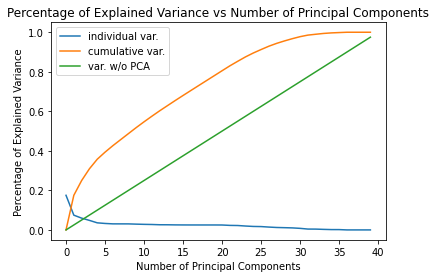

In [125]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)
num_components = len(pca.components_)
xs = [i for i in range(num_components)]
cum_var = [np.sum(pca.explained_variance_ratio_[0:i]) for i in range(num_components)]
plt.plot(xs, pca.explained_variance_ratio_, label="individual var.")
plt.plot(xs, cum_var, label="cumulative var.")
plt.plot(xs, [i/len(xs) for i in xs], label="var. w/o PCA")
plt.xlabel("Number of Principal Components")
plt.ylabel("Percentage of Explained Variance")
plt.legend(loc = "best")
plt.title("Percentage of Explained Variance vs Number of Principal Components")
plt.show()

# 7 - Ensemble Method

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

In [52]:
# generate list of models
def create_adaboost_models():
    models = dict()
    # number of n_estimators
    n_trees = [10, 50, 100, 250, 500, 1000]
    #create model with chosen hyperparamters of max_depth = 1 & learning_rate = 1.0
    for n in n_trees:
        models[str(n)] = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=n, learning_rate=0.01)
    return models

In [53]:
#evaluate models using Kfold Cross Validation
def cv_adaboost_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    #KFold Cross Validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    #Results
    scores = cross_val_score(model, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [54]:
def feature_importance_adaboost_model(model, X_train):
     pd.Series(model.feature_importances_,index=list(X_train)).sort_values().plot(title="Model", kind="barh", figsize=(10,10))

>n_estimators:10, Score: 0.910 (0.007)
>n_estimators:50, Score: 0.910 (0.007)
>n_estimators:100, Score: 0.884 (0.018)
>n_estimators:250, Score: 0.873 (0.007)
>n_estimators:500, Score: 0.924 (0.007)
>n_estimators:1000, Score: 0.953 (0.006)


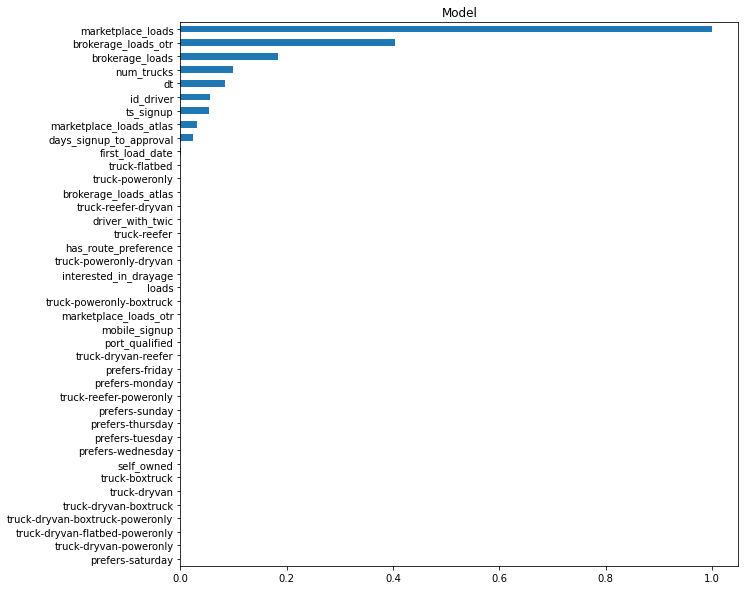

In [55]:
#perform adaboost and assess models
models = create_adaboost_models()
results, names = list(), list()
for name, model in models.items():
    scores = cv_adaboost_model(model, X_train, y_train, X_test, y_test)
    results.append(scores)
    names.append(name)
    print('>n_estimators:%s, Score: %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
    feature_importance_adaboost_model(model, X_train)
    

# 8 - Neural Network

In [131]:
clf = MLPClassifier(hidden_layer_sizes=(100,), verbose=False)
clf.fit(np.array(X_train), y_train)

MLPClassifier()

In [132]:
clf.score(np.array(X_test), y_test)

1.0

In [133]:
# learning curves
X_arr, y_arr = np.array(X_train), np.array(y_train)
cutoffs = 10

step = len(X_arr) // cutoffs
cuts = [step * i for i in range(1, cutoffs + 1)]
train_scores = []
test_scores = []

for cut in cuts:
    X_arr_cut = X_arr[:cut]
    y_arr_cut = y_arr[:cut]
    clf = MLPClassifier(hidden_layer_sizes=(100,))
    clf.fit(X_arr_cut, y_arr_cut)
    train_scores.append(clf.score(X_arr_cut, y_arr_cut))
    test_scores.append(clf.score(X_test, y_test))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


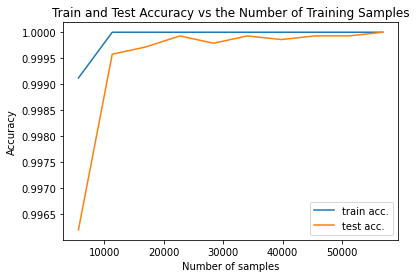

In [134]:
# plot
plt.plot(cuts, train_scores, label="train acc.")
plt.plot(cuts, test_scores, label="test acc.")
plt.legend(loc = "best")
plt.xlabel("Number of samples")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy vs the Number of Training Samples")
plt.show()

In [135]:
# Perform cross validation
from sklearn.model_selection import cross_val_score
cross_val_scores = cross_val_score(clf, X_arr, y_arr, cv=10)
print(cross_val_scores)

[0.99982413 1.         1.         1.         1.         0.99982413
 1.         1.         1.         1.        ]


In [136]:
print(np.mean(cross_val_scores))

0.9999648258881464


In [137]:
# Alternate model
clf2 = MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', solver='sgd', momentum=0.9)
cvs2 = cross_val_score(clf2, X_arr, y_arr, cv=10)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

In [138]:
print(np.mean(cvs2))

0.9562235440098673


# 10 - Custom Model

In [139]:
# get training data
X_og, y_og = get_Xy(train_df, standardize=False, aggregate=False, testdata=False)
X_og["label"] = y_og

In [140]:
# leverages the fact that all high performing truckers have multiple rows
class really_good_model():
    def __init__(self):
        self.data = None
    def fit(self, X, y = None):
        self.data = X
    def predict(self, driver_ids):
        preds = []
        for d_id in driver_ids:
            # if the d_id is in the X_og data, then return the label
            if len(self.data[self.data["id_driver"] == d_id]) > 0:
                lab = self.data[self.data["id_driver"] == d_id].label.iloc[0]
                preds.append(lab)
            # else, statistically very unlikely that label is 1
            else:
                preds.append(0)
        return np.array(preds)
    def score(self, driver_ids, labels, normalized = True):
        
        # get predictions
        preds = self.predict(driver_ids)
        lab_arr = np.array(labels)
        diffs = np.sum(preds == lab_arr)
        
        # return score
        if normalized:
            return diffs / len(preds)
        else:
            return diffs

In [141]:
from sklearn.model_selection import KFold
n_splits = len(X_og) // 1000
kf = KFold(n_splits=n_splits, shuffle=True)

In [142]:
# perform cross validation

test_scores = []
counter = 0
for train_idx, test_idx in kf.split(X_og):
    dm = really_good_model()
    dm.fit(X_og.iloc[train_idx])
    score = dm.score(X_og.iloc[test_idx]["id_driver"], X_og.iloc[test_idx]["label"])
    test_scores.append(score)
    if counter % 10 == 0:
        print(score)
    counter += 1
    

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [143]:
# get kaggle predictions
X_test = pd.read_csv("score_V3.csv")
dm = really_good_model()
dm.fit(X_og)
preds = dm.predict(X_test["id_driver"])
np.sum(preds)

119

In [144]:
preds_df = pd.DataFrame()
preds_df["ID"] = X_test["Unnamed: 0"]
preds_df["predicted"] = preds
preds_df.to_csv("submission.csv", index=False)

In [145]:
train_dataset = pd.read_csv("training_dataset_V3.csv")

In [146]:
train_dataset["d_numeric"] = pd.to_numeric(train_dataset.most_recent_load_date.str.replace('-', ''))
train_dataset["recent_enough"] = train_dataset["d_numeric"] > 20210210
train_dataset

,Unnamed: 0,dt,weekday,year,id_driver,id_carrier_number,dim_carrier_type,dim_carrier_company_name,home_base_city,home_base_state,...,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads,d_numeric,recent_enough
0,0,2019-12-16,Monday,2019,21350,U0109015,Owner Operator,CA&F TRUCKING,Maywood,CA,...,2,0,438,438,0,45,45,483,20210217,True
1,1,2021-01-15,Friday,2021,36437,C0097727,Fleet,New opportunities inc,Los Angeles,CA,...,1,2,72,74,0,1,1,75,20210203,False
2,2,2019-12-26,Thursday,2019,19323,U0107081,Owner Operator,RAS,Compton,CA,...,1,0,180,180,0,2,2,182,20200925,False
3,3,2021-02-10,Wednesday,2021,34809,C0094651,Fleet,NFS asset Drayage,Lynwood,CA,...,3,0,0,0,0,0,0,62,20210217,True
4,4,2017-07-24,Monday,2017,4728,U0094376,Owner Operator,joes transportation,Norco,CA,...,2,57,0,57,314,0,314,371,20171011,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83409,83409,2019-05-24,Friday,2019,7879,C0090913,Fleet,the custom companies inc,Northlake,IL,...,1,0,0,0,346,0,346,346,20210214,True
83410,83410,2017-08-08,Tuesday,2017,619,C0090094,Fleet,MC Express Trucking LLC,Rosarito,B.C.,...,1,0,0,0,44,0,44,44,20180206,False
83411,83411,2020-09-04,Friday,2020,15666,U0103746,Owner Operator,iraheta logistics,Moreno Valley,CA,...,5,14,691,705,0,52,52,757,20210129,False
83412,83412,2017-02-14,Tuesday,2017,4728,U0094376,Owner Operator,joes transportation,Norco,CA,...,3,57,0,57,314,0,314,371,20171011,False


In [147]:
train_dataset["enough_loads"] = train_dataset["total_loads"] > train_dataset["total_loads"].quantile(0.75)
train_dataset["predicted"] = pd.to_numeric((train_dataset["enough_loads"]) & (train_dataset["recent_enough"]))
np.sum(np.array(train_dataset["predicted"])) / len(train_dataset)

0.13961685088834008

In [148]:
dm = really_good_model()
X_train = pd.DataFrame()
X_train["id_driver"] = train_dataset["id_driver"]
X_train["label"] = train_dataset["predicted"]
dm.fit(X_train)
preds = dm.predict(X_test["id_driver"])
np.sum(preds)
preds_df = pd.DataFrame()
preds_df["ID"] = X_test["Unnamed: 0"]
preds_df["predicted"] = preds
preds_df.to_csv("submission.csv", index=False)